In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from empiricaldist import Pmf
from scipy.stats import binom

In [2]:
# Rehashing the Euro Problem

hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250

In [3]:
def update_binomial(pmf, data):
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [4]:
update_binomial(pmf, data)

In [5]:
cumulative = pmf.cumsum()

In [6]:
%matplotlib inline

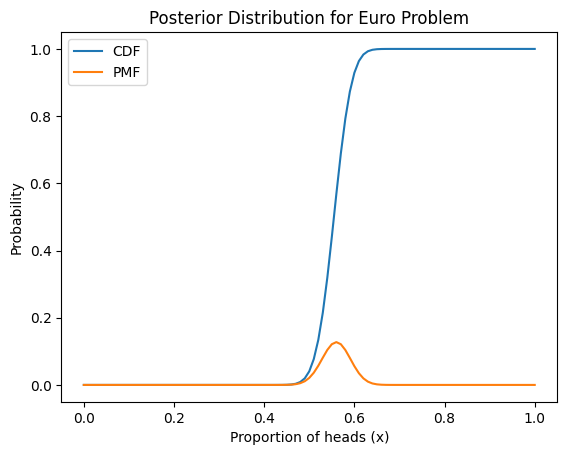

In [7]:
cumulative.plot(label="CDF", title="Posterior Distribution for Euro Problem")
pmf.plot(label="PMF", xlabel="Proportion of heads (x)", ylabel="Probability")
plt.legend()

In [8]:
cumulative[0.61]

np.float64(0.9638303193984253)

In [9]:
from scipy.interpolate import interp1d

In [10]:
ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

In [11]:
cdf = pmf.make_cdf()

In [12]:
cdf[0.61]

np.float64(0.9638303193984253)

In [13]:
cdf[0.615]

KeyError: 0.615

In [14]:
cdf(0.615)

array(0.96383032)

In [15]:
cdf.quantile(0.9638303)

array(0.61)

In [16]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

In [ ]:
# can create the equivalent pmf from a cdf
pmf = cdf.make_pmf()

In [17]:
def make_die(sides):
    outcomes = np.arange(1, sides+1)
    die = Pmf(1/sides, outcomes)
    return die

In [18]:
def add_dist(pmf1, pmf2):
    """Compute the distribution of a sum."""
    res = Pmf()
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            q = q1 + q2
            p = p1 * p2
            res[q] = res(q) + p
    return res

In [19]:
def add_dist_seq(seq):
    """Compute Pmf of the sum of values from seq."""
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

In [20]:
# If we create a 6-sided die and a sequence that refers to it 3 times

die = make_die(6)
dice = [die] * 3

pmf_3d6 = add_dist_seq(dice)

<Axes: title={'center': 'Distribution of outcomes'}, xlabel='Outcome', ylabel='PMF'>

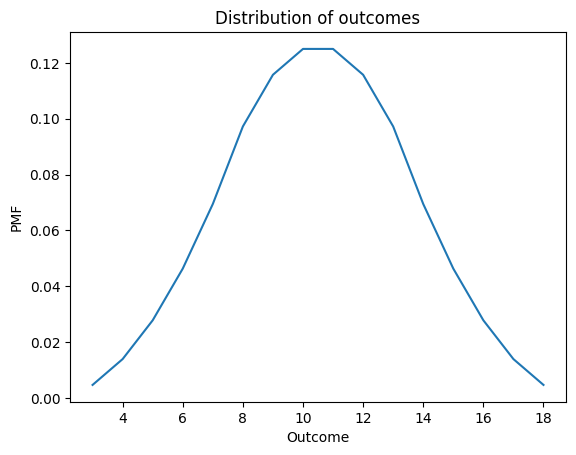

In [21]:
pmf_3d6.plot(xlabel="Outcome", ylabel="PMF", title="Distribution of outcomes")

In [22]:
# Distribution of the sum of the best 3 of 4 rolls - estimated by simulating 10,000 rolls

n = 10000
a = np.random.randint(1, 7, size=(n, 4))

In [23]:
a.sort(axis=1) # sort the rows of the array of random values
t = a[:, 1:].sum(axis=1) # select the last 3 columns and add them, to create an array with 1 column and 10000 rows

In [24]:
pmf_best3 = Pmf.from_seq(t)

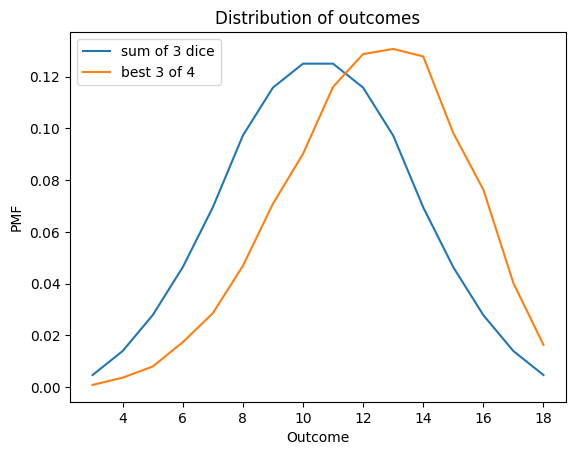

In [26]:
pmf_3d6.plot(label="sum of 3 dice", xlabel="Outcome", ylabel="PMF", title="Distribution of outcomes")
pmf_best3.plot(label="best 3 of 4")
plt.legend()

In [27]:
# Calc the distribution for the maximum of 6 attributes, which are each the sum of best 3 of 4 dice throws

# First, get the cdf of the "best 3 of 4" pmf

cdf_best3 = pmf_best3.make_cdf()

In [28]:
# Now draw 6 values from this distribution
# Pr that all 6 are <= x is Cdf(x)^6, or cdf_best3**6
# A CDF of the maximum of the 6 values can be created as:

from empiricaldist import Cdf

In [29]:
cdf_max6 = Cdf(cdf_best3**6)

In [30]:
cdf_3d6 = pmf_3d6.make_cdf()

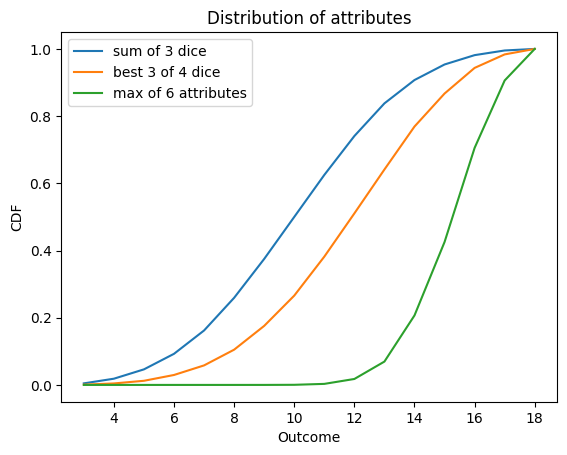

In [33]:
cdf_3d6.plot(label="sum of 3 dice", title="Distribution of attributes")
cdf_best3.plot(label="best 3 of 4 dice", xlabel="Outcome")
cdf_max6.plot(label="max of 6 attributes", ylabel="CDF")
plt.legend()

In [ ]:
# Can also calculate the CDF of the maximum by:
cdf_max_dist6 = cdf_best3.max_dist(6)

In [34]:
# Now to compute the distribution of the minimum of the 6 attributes
# This uses the complementary CDF

prob_gt = 1 - cdf_best3

# If we draw 6 values from this distribution, the probability that all 6 exceed x is:

prob_gt6 = prob_gt**6

# If all 6 exceed x, their minimum exceeds x, so prob_gt6 is the complementary CDF of the minimum, which is computed as:

prob_le6 = 1 - prob_gt6
cdf_min6 = Cdf(prob_le6)

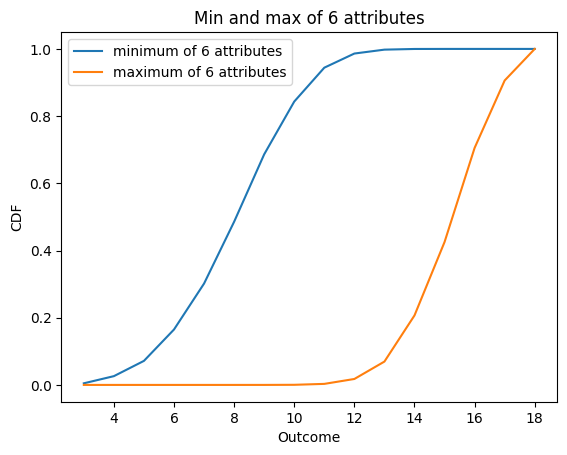

In [35]:
cdf_min6.plot(label="minimum of 6 attributes", title="Min and max of 6 attributes")
cdf_max6.plot(label="maximum of 6 attributes", xlabel="Outcome", ylabel="CDF")
plt.legend()

In [ ]:
# The CDF of the minimum can also be computed as:
cdf_min_dist6 = cdf_best3.min_dist(6)

In [36]:
# Distributions that are mixtures of other distributions

d4 = make_die(4)
d6 = make_die(6)

# Probability of inflicting 1 point of damage with either weapon
prob_1 = (d4(1) + d6(1)) / 2

# This is a little different for the 5 and 6 point outcomes, as these can't be inflicted with the 4-point weapon
prob_6 = (d4(6) + d6(6)) / 2

prob_1

np.float64(0.20833333333333331)

In [37]:
prob_6

np.float64(0.08333333333333333)

In [38]:
# We can loop through the possible combinations and compute their probabilities,
# or we can use the + operator

mix1 = (d4 + d6) / 2

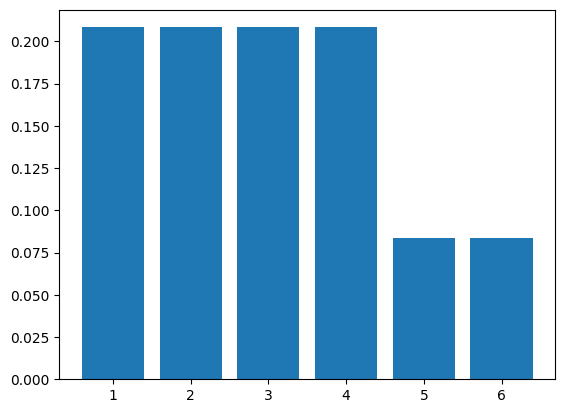

In [39]:
mix1.bar()

In [40]:
# You're attacked by 3 monsters, 1 at random each round
# One has a 4-point weapon, 2 have 6-point weapons

mix2 = (d4 + 2*d6) / 3

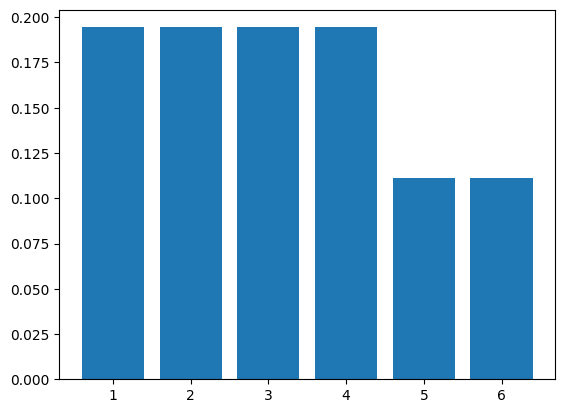

In [41]:
mix2.bar()

In [42]:
# We can compute the total damage done by all parties in 1 round

total_damage = Pmf.add_dist(mix1, mix2)

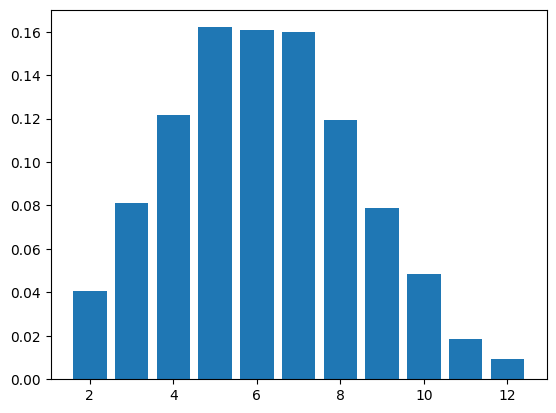

In [43]:
total_damage.bar()

In [44]:
# Now we add 3 more monsters, each with an 8-point weapon

# Pmf for a randomly chosen monster
hypos = [4, 6, 8]
counts = [1, 2, 3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


In [45]:
# pmf_dice represents the number of sides on the die we roll, and the probability of rolling each one
# Next we create a sequence of Pmf's representing the dice

dice = [make_die(sides) for sides in hypos]

In [46]:
# To compute the distribution of the mixture, we compute the weighted average of the dice using the probabilities in pmf_dice as weights

pd.DataFrame(dice)

,1,2,3,4,5,6,7,8
0,0.250000,0.250000,0.250000,0.250000,NaN,NaN,NaN,NaN
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
2,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


In [47]:
pd.DataFrame(dice).fillna(0)

,1,2,3,4,5,6,7,8
0,0.250000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000,0.000
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000,0.000
2,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


In [48]:
# Then we multiply each row of this data frame by the probabilities in pmf_dice
# This is easier if we transpose the data frame

df = pd.DataFrame(dice).fillna(0).transpose()

In [49]:
df

,0,1,2
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


In [50]:
df *= pmf_dice.ps

In [51]:
df

,0,1,2
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


In [52]:
# Then we add up the weighted distributions
df.sum(axis=1) #axis=1 means we sum across rows. This yields a pandas Series object.

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

In [53]:
# This is a more general function that creates a weighted mixture of distributions
# The 1st parameter is a Pmf mapping hypotheses to probabilities
# The 2nd parameter is a sequence of Pmf objects, one for each hypothesis

def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions"""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

In [54]:
# So
mix = make_mixture(pmf_dice, dice)

In [55]:
mix

,probs
1,0.159722
2,0.159722
3,0.159722
4,0.159722
5,0.118056
6,0.118056
7,0.062500
8,0.062500


In [65]:
# Exercise 7-1

#std_dist = pd.Series([15, 14, 13, 12, 10, 8]) # The solution approaches this differently

standard = [15, 14, 13, 12, 10, 8]
cdf_standard = Cdf.from_seq(standard)

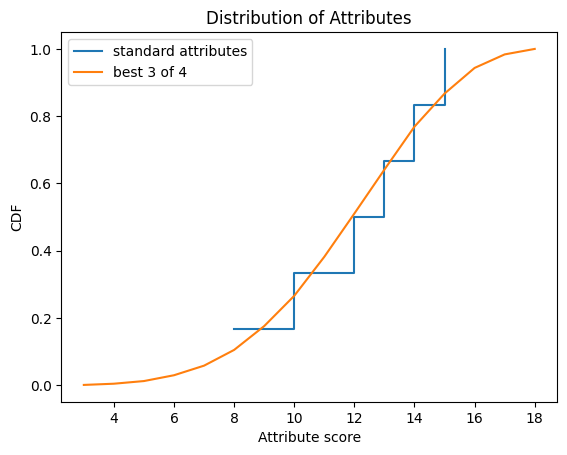

In [67]:
cdf_standard.step(label="standard attributes", title="Distribution of Attributes")
cdf_best3.plot(label="best 3 of 4", xlabel="Attribute score", ylabel="CDF")
plt.legend()

In [68]:
# Means
cdf_standard.mean(), cdf_best3.mean()

(np.float64(12.0), np.float64(12.2515))

In [70]:
# Standard deviations

cdf_standard.std(), cdf_best3.std()

(np.float64(2.3804761428476167), np.float64(2.8557044227300556))

In [71]:
# Probability that a single attribute is less than 8

cdf_best3.lt_dist(8)

np.float64(0.0581)

In [72]:
# Probability that at least 1 of 6 attributes is less than 8

cdf_min6.lt_dist(8)

np.float64(0.3017213214200759)

In [73]:
# Probability that a single attribute is greater than 15

cdf_best3.gt_dist(15)

np.float64(0.13280000000000003)

In [74]:
# Probability that at least 1 attribute is greater than 15

cdf_max6.gt_dist(15)

np.float64(0.5746801861120294)

In [76]:
# Exercise 7-2

hypos = [6, 8, 10]
prior = Pmf(1, hypos)

likelihood = [1/6, 1/8, 1/10]

posterior = prior * likelihood
posterior.normalize()
posterior

,probs
6,0.425532
8,0.319149
10,0.255319


In [77]:
dice = [make_die((sides)) for sides in hypos]

mix = make_mixture(posterior, dice)

In [78]:
mix # YES! Though I needed help.

,probs
1,0.136348
2,0.136348
3,0.136348
4,0.136348
5,0.136348
6,0.136348
7,0.065426
8,0.065426
9,0.025532
10,0.025532


In [79]:
# Exercise 7-3

# Not sure how to tackle this one
# The solution starts by generating a year's worth of data with the given parameters

mean = 950
std = 50

np.random.seed(17)
sample = np.random.normal(mean, std, size=365)

In [81]:
# Next the solution creates the CDF of the data sample

cdf = Cdf.from_seq(sample)

In [82]:
# Then we calculate the CDF of the maximum of N draws, for several values of N

for n in range(1, 10):
    cdf_max = cdf.max_dist(n)
    print(n, cdf_max.mean())

1 949.7832346541664
2 978.4666876067706
3 992.7589004318227
4 1002.0372868686195
5 1008.8226939493089
6 1014.142390301017
7 1018.507694202546
8 1022.2066965318894
9 1025.416321307913


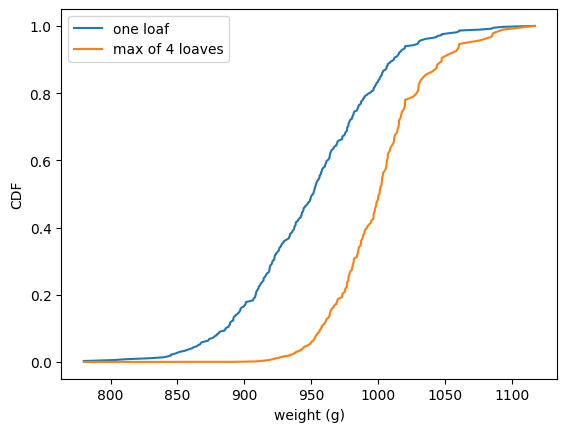

In [85]:
cdf.plot(label="one loaf", xlabel="weight (g)", ylabel="CDF")
cdf.max_dist(4).plot(label="max of 4 loaves")
plt.legend()